In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from multiprocessing import cpu_count

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split 


# Preprocessing

In [4]:
# BLOG ARTICLES DATA

df_filed = pd.read_csv('./data/files_all_articles.csv') #Fathom 
df_A_theblondeabroad = pd.read_csv('./data/articles_theblondeabroad.csv')
df_A_amateurtraveler = pd.read_csv('./data/articles_amateurtraveler.csv')
df_A_bemytravelmuse = pd.read_csv('./data/articles_bemytravelmuse.csv')
df_A_nerdnomads = pd.read_csv('./data/articles_nerdnomads.csv')
df_A_ordinarytraveler = pd.read_csv('./data/articles_ordinarytraveler.csv')

# Fathom data was saved without ignoring the index ...
df_filed.drop(columns=['Unnamed: 0'], inplace=True)

# Combined Web-Scraped Blog Articles
df_A_ALL_filed = [df_filed, df_A_theblondeabroad, df_A_amateurtraveler,
          df_A_bemytravelmuse, df_A_nerdnomads, df_A_ordinarytraveler]

df_blogs = pd.concat(df_A_ALL_filed, ignore_index=True)
df_blogs['all_words'] = df_blogs['title'] + df_blogs['text']


# SUBREDDIT POSTS DATA

df_reddit = pd.read_csv('./data/subreddits.csv')

print('# of blog articles:', df_blogs.shape[0])
print('# of subreddit posts:', df_reddit.shape[0])
print()
print('# of distinct countries in the blog articles:',len(df_blogs['country'].value_counts()))
print()

# COMBINE DATAFRAMES TO INCLUDE ALL BLOG ARTICLES & SUBREDDIT POSTS
df_combined = pd.concat([df_blogs, df_reddit], ignore_index=True)


min_length = 5    # Minimum # of articles & posts per country

# COUNTRIES WITH AT LEAST THE MIN_LENGTH # of ARTICLES FILED & SEARCHED POSTS
countries = [i for i in df_combined['country'].value_counts()[df_combined['country'].value_counts() >= min_length].index]
print(f'# of countries with at least {min_length} articles and posts:',len(countries))

# DF FILTERED TO COUNTRIES MEETING MINIMUM CRITERIA
df = df_combined[df_combined['country'].isin(countries)]
print('# of resulting articles and posts:',df.shape[0])

df.to_csv('./data/final_df.csv', index=False)

# of blog articles: 2498
# of subreddit posts: 31568

# of distinct countries in the blog articles: 129

# of countries with at least 5 articles and posts: 157
# of resulting articles and posts: 34012


In [7]:
# TRAIN TEST SPLIT TITLE & BODY TEXT WITH LABELED COUNTRY
X = df['all_words']
y = df['country']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.05, stratify=y, random_state=42)

In [8]:
# PREPARE TEXT TO FEED INTO MODEL

def text_to_words(text, stops = set(ENGLISH_STOP_WORDS), lemmatize=True):
    tokenizer = RegexpTokenizer(r'\w+')
    lemmatizer = WordNetLemmatizer()
    
    tokens = tokenizer.tokenize(text)           # identifies words in the body of text
    tokens_lower = [t.lower() for t in tokens]     # lowercase each word
    if lemmatize==True:
        tokens_lem = [lemmatizer.lemmatize(i) for i in tokens_lower]    # identifies root of each word
    meaningful_words = [w for w in tokens_lem if not w in stops]    # Remove stopwords
    
    return(" ".join(meaningful_words))    # Join the words back into one string separated by spaces


words_train_ls = [text_to_words(a) for a in X_train]
tagged_data = [TaggedDocument(words=words_train_ls, tags=list(y_train))]

words_testls = [text_to_words(b) for b in X_test]
tagged_testdata = [TaggedDocument(words=words_testls, tags=list(y_test))]

In [9]:

# A RegexpTokenizer splits a string into substrings using regular expressions.
# RegexpTokenizer(r'\w+') 
    # identifies words, including contraction words
# RegexpTokenizer('\w+|\$[\d\.]+|\S+') 
    # splits tokens up by spaces or by periods that are not attached to a digit.
# RegexpTokenizer('\s+', gaps=True) 
    # will identify the spaces. 
    # By setting gaps = True, we're grabbing everything else: thus, we're splitting our tokens up by spaces.
# RegexpTokenizer('[A-Z]\w+')    
    # returns only words that begin with a capital letter.



## Words per Post

In [10]:
# COUNT VECTORIZER #
stops = list(ENGLISH_STOP_WORDS) + ['like']

cv = CountVectorizer(min_df=10, stop_words=stops)

vect = cv.fit_transform(df['all_words'])

df_vect = pd.DataFrame(vect.todense(), columns=cv.get_feature_names())

top_words = list(df_vect.sum().sort_values().tail(20).index)

# df_vect.sum().sort_values().tail(20).plot.barh();

In [11]:
# TFIDF #
tf = TfidfVectorizer(min_df=10, stop_words=ENGLISH_STOP_WORDS)
tfvect = tf.fit_transform(df['all_words'])

df_tfvect = pd.DataFrame(tfvect.todense(), columns=tf.get_feature_names())
# df_tfvect.sum().sort_values().tail(20).plot.barh();

tf_top_words = list(df_tfvect.sum().sort_values().tail(20).index)

## Doc2Vec

In [12]:
# TRAIN MODEL

# Doc2Vec parameters

vector_size = 150    # dimensions of word vectors
window_size = 8      # How many "context words" - The maximum distance between the current and predicted words
min_count = 5        # Ignores words below this threshold frequency
sampling_threshold = 1e-5    # The threshold for configuring which higher-frequency words are 
                                                  # randomly downsampled, useful range is (0, 1e-5).
negative_size = 5
train_epoch = 50
dm = 0 #0 = dbow; 1 = dmpv
worker_count = cpu_count() - 1    # Number of "worker threads" to use (parallelizes process)


model = Doc2Vec(tagged_data,    # corpus of data
                  
                  size=vector_size,
                  window=window_size,
                  min_count=min_count,
                  sample=sampling_threshold,
                  workers=worker_count,
                  
                  hs=0,    # If 1, hierarchical softmax will be used for model training.
                              # If set to 0, and `negative` is non-zero, negative sampling will be used.
                  
                  dm=dm,    # Defines the training algorithm. If `dm=1`, 'distributed memory' (PV-DM) is used.
                              # Otherwise, `distributed bag of words` (PV-DBOW) is employed.
                  
                  negative=negative_size,  # If > 0, negative sampling will be used, the int for negative 
                                             # specifies how many "noise words" should be drawn 
                                             # (usually between 5-20). If set to 0, no negative sampling is used. 
                  
                  dbow_words=1,  # If set to 1 trains word-vectors (in skip-gram fashion) simultaneous with DBOW
                                      # doc-vector training; If 0, only trains doc-vectors (faster). 
                  
                  dm_concat=1,    # If 1, use concatenation of context vectors rather than sum/average;
                                 # Note concatenation results in a much-larger model, as the input is no longer
                                 # the size of one (sampled or arithmetically combined) word vector, 
                                 # but the size of the tag(s) and all words in the context strung together.
                  
                  pretrained_emb=None,    
                  iter=train_epoch)    

# Save model
model.save('d2v_model.bin')

# Code adapted from https://github.com/eellak/gsoc2018-3gm/wiki/Document-Embeddings-with-Doc2Vec

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/models/doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [13]:
model= Doc2Vec.load("d2v_model.bin")

print("Actual Country:", tagged_testdata[0][1][0])

v1 = model.infer_vector([w for w in tagged_testdata[0][0][0]])

print('Similar to Article Vector:', model.docvecs.most_similar([v1]))
print()
print('Similar to the Country Label:', model.docvecs.most_similar(tagged_testdata[0][1][0]))

Actual Country: Portugal
Similar to Article Vector: [('Australia', 0.012205976992845535), ('Thailand', 0.011617237702012062), ('Indonesia', 0.0102264154702425), ('France', 0.009734464809298515), ('Vietnam', 0.009404250420629978), ('Japan', 0.008210856467485428), ('Greece', 0.007611691951751709), ('Portugal', 0.006830520462244749), ('New Zealand', 0.006535639520734549), ('Poland', 0.00627489946782589)]

Similar to the Country Label: [('Ireland', 0.9994216561317444), ('Switzerland', 0.998757004737854), ('Indonesia', 0.9983217716217041), ('Greece', 0.9981710314750671), ('Cambodia', 0.9971235394477844), ('Peru', 0.9962897896766663), ('Singapore', 0.9958539605140686), ('Colombia', 0.993141770362854), ('China', 0.9915820360183716), ('Spain', 0.9909965991973877)]


In [14]:
len(tagged_testdata[0][1])

1701

In [15]:
model= Doc2Vec.load("d2v_model.bin")

In [16]:
# QUANTIFY HOW MUCH THE PREDICTIONS VARY

def how_similar_recomm(countries, vector=False):
    range_similar_countries = 30
    all_preds = []
    similarity_scores = []
    for c in countries:
        for n in range(range_similar_countries):
            prediction = {}
            prediction['actual_country'] = c
            sim_country, score = model.docvecs.most_similar(c, topn=range_similar_countries)[n]
            prediction['similar_country'] = sim_country
            prediction['score'] = score
            similarity_scores.append(score)
            all_preds.append(prediction)
            
    if vector!= False:
        for v in vector:
            for n in range(range_similar_countries):
                prediction = {}
                prediction['actual_country'] = c
                sim_country, score = model.docvecs.most_similar(v, topn=range_similar_countries)[n]
                prediction['similar_v_country'] = sim_country
                prediction['score_v'] = score
                similarity_scores.append(score)
                all_preds.append(prediction)
       
    df_all_country_similarities = pd.DataFrame(all_preds)


    scores = {}
    scores['min_similarity'] = df_all_country_similarities.groupby(by=['actual_country'])['score'].min()
    scores['max_similarity'] = df_all_country_similarities.groupby(by=['actual_country'])['score'].max() 
    if vector != False:
        scores['min_v_similarity'] = df_all_country_similarities.groupby(by=['actual_country'])['score_v'].min()
        scores['max_v_similarity'] = df_all_country_similarities.groupby(by=['actual_country'])['score_v'].max() 
        
    df_scores = pd.DataFrame(scores)

    df_scores['dissimilarity_scores'] = scores['max_similarity'] - scores['min_similarity']
    if vector != False:
        df_scores['dissimilarity_v_scores'] = scores['max_v_similarity'] - scores['min_v_similarity']


    similarity_max = df_scores['max_similarity'].max()
    similarity_max_mean = df_scores['max_similarity'].mean()
    similarity_min = df_scores['min_similarity'].min()
    similarity_min_mean = df_scores['min_similarity'].mean()
    avg_dissimilarity = df_scores['dissimilarity_scores'].mean()
    if vector != False:
        similarity_v_max = df_scores['max_v_similarity'].max()
        similarity_v_max_mean = df_scores['max_v_similarity'].mean()
        similarity_v_min = df_scores['min_v_similarity'].min()
        similarity_v_min_mean = df_scores['min_v_similarity'].mean()
        avg_v_dissimilarity = df_scores['dissimilarity_v_scores'].mean()

    max_c_similar_cnt = df_all_country_similarities['similar_country'].value_counts().max()
    min_c_similar_cnt = df_all_country_similarities['similar_country'].value_counts().min()
    mean_c_similar_cnt = df_all_country_similarities['similar_country'].value_counts().mean()
    
    if vector != False:
        max_cv_similar_cnt = df_all_country_similarities['similar_v_country'].value_counts().max()
        min_cv_similar_cnt = df_all_country_similarities['similar_v_country'].value_counts().min()
        mean_cv_similar_cnt = df_all_country_similarities['similar_v_country'].value_counts().mean()

    print('Maximum Similarity Score:', similarity_max)
    print('Average Maximum Similarity Score:', similarity_max_mean)
    print()
    print('Minimum Similarity Score:', similarity_min)
    print('Average Minimum Similarity Score:', similarity_min_mean)
    print()
    print('Average Dissimilarity of Top Predictions:', avg_dissimilarity)
    print()
    print('Average Count of Countries in Top Predictions:', mean_c_similar_cnt)
    print('Maximum Count of Countries in Top Predictions:', max_c_similar_cnt)
    print('Average Count of Countries in Top Predictions:', min_c_similar_cnt)
    print()

    if vector != False:
        print('Maximum Vector Similarity Score:', similarity_v_max)
        print('Average Maximum Vector Similarity Score:', similarity_v_max_mean)
        print()
        print('Minimum Vector Similarity Score:', similarity_v_min)
        print('Average Minimum Vector Similarity Score:', similarity_v_min_mean)
        print()
        print('Average Dissimilarity of Top Vector Predictions:', avg_v_dissimilarity)
        print()
        print('Average Count of Countries in Top Vector Predictions:', mean_cv_similar_cnt)
        print('Maximum Count of Countries in Top Vector Predictions:', max_cv_similar_cnt)
        print('Average Count of Countries in Top Vector Predictions:', min_cv_similar_cnt)
        print()

    return df_scores

In [17]:
print('# ALL COUNTRIES #')
how_similar_recomm(countries)
print()
print('# TEST COUNTRIES #')
how_similar_recomm(countries=tagged_testdata[0][1]) #, vector=tagged_testdata[0][0])
print()

# ALL COUNTRIES #
Maximum Similarity Score: 0.99964439868927
Average Maximum Similarity Score: 0.998448231417662

Minimum Similarity Score: 0.858163595199585
Average Minimum Similarity Score: 0.9612176167737146

Average Dissimilarity of Top Predictions: 0.037230614643947335

Average Count of Countries in Top Predictions: 30.0
Maximum Count of Countries in Top Predictions: 46
Average Count of Countries in Top Predictions: 17


# TEST COUNTRIES #
Maximum Similarity Score: 0.99964439868927
Average Maximum Similarity Score: 0.9984953358565292

Minimum Similarity Score: 0.858163595199585
Average Minimum Similarity Score: 0.9653488315948068

Average Dissimilarity of Top Predictions: 0.033146504261722304

Average Count of Countries in Top Predictions: 325.03184713375794
Maximum Count of Countries in Top Predictions: 1301
Average Count of Countries in Top Predictions: 6




In [18]:
# MODEL EVALUATION

# BASELINE VALUES
y.value_counts(normalize=True).head(10)


India        0.033518
Germany      0.032959
Vietnam      0.031224
Australia    0.030489
Thailand     0.029754
Canada       0.029490
Italy        0.029460
France       0.028549
Japan        0.026638
Mexico       0.025697
Name: country, dtype: float64

In [19]:
model.docvecs.most_similar(tagged_testdata[0][1][0])

[('Ireland', 0.9994216561317444),
 ('Switzerland', 0.998757004737854),
 ('Indonesia', 0.9983217716217041),
 ('Greece', 0.9981710314750671),
 ('Cambodia', 0.9971235394477844),
 ('Peru', 0.9962897896766663),
 ('Singapore', 0.9958539605140686),
 ('Colombia', 0.993141770362854),
 ('China', 0.9915820360183716),
 ('Spain', 0.9909965991973877)]

In [20]:
model.docvecs.most_similar([model.infer_vector([w for w in tagged_testdata[0][0][0]])])

[('Australia', 0.012205976992845535),
 ('Thailand', 0.011617237702012062),
 ('Indonesia', 0.0102264154702425),
 ('France', 0.009734464809298515),
 ('Vietnam', 0.009404250420629978),
 ('Japan', 0.008210856467485428),
 ('Greece', 0.007611691951751709),
 ('Portugal', 0.006830520462244749),
 ('New Zealand', 0.006535639520734549),
 ('Poland', 0.00627489946782589)]

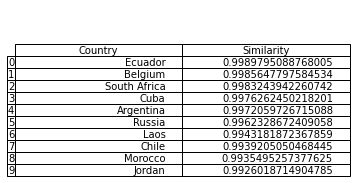

In [28]:
# Get recommendations
usa_recomm = model.docvecs.most_similar('United States')

df_usa_recomm = pd.DataFrame(usa_recomm, columns=['Country', 'Similarity'])

ax = plt.subplot(512, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df_usa_recomm)  # where df is your data frame

plt.savefig('./images/usa_recommendations_table.png')

In [22]:
# Get recommendations
model.docvecs.most_similar('Russia')

[('Ecuador', 0.9973948001861572),
 ('Cuba', 0.9966560006141663),
 ('United States', 0.9962328672409058),
 ('South Africa', 0.9959067702293396),
 ('Israel', 0.9958263039588928),
 ('Laos', 0.9942963123321533),
 ('Sweden', 0.9942832589149475),
 ('Taiwan', 0.994129478931427),
 ('Morocco', 0.9936922788619995),
 ('Argentina', 0.993605375289917)]

# Make Recommendations based on Facebook status messages

In [23]:
# Source: Donald Trump's Facebook Statuses + Reaction Counts (as of 10_17_16, @minimaxir) - 
# . https://data.world/bgadoci/trumps-facebook-statuses

df_fb = pd.read_csv('./data/DonaldTrump_facebook_statuses.csv')

In [25]:
# Filter dataframe to only posts from the year 2016
df_fb['status_published']= pd.to_datetime(df_fb['status_published'])
df_2016fb = df_fb[df_fb.status_published.dt.year == 2016].copy()

# Aggregate and prepare status messages to feed into the model
fb_posts = list(df_2016fb['status_message'])
fb_text = ' '.join([str(p).strip() for p in fb_posts])

# Convert words to paragraph vector
fb_vec = model.infer_vector([str(w).strip() for w in fb_text])

# Get recommendations
fb_recomm = model.docvecs.most_similar([fb_vec], topn=50)

df_fb_recomm = pd.DataFrame(fb_recomm, columns=['Country', 'Similarity'])

ax = plt.subplot(512, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, df_fb_recomm[:10])  # where df is your data frame

plt.savefig('./images/fb_recommendations_table.png')

[('Saudi Arabia', 0.17405492067337036),
 ('Ghana', 0.17097438871860504),
 ('Moldova', 0.16999314725399017),
 ('Botswana', 0.16942322254180908),
 ('Madagascar', 0.16935278475284576),
 ('Namibia', 0.16909722983837128),
 ('Venezuela', 0.16776232421398163),
 ('Bahrain', 0.16573859751224518),
 ('Mozambique', 0.165486678481102),
 ('Kuwait', 0.1652957648038864)]

In [31]:
print(len(df_fb))
df_fb.head()

4160


,status_id,status_message,link_name,status_type,status_link,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,153080620724_10157915294545725,Beautiful evening in Wisconsin- THANK YOU for ...,Timeline Photos,photo,https://www.facebook.com/DonaldTrump/photos/a....,2016-10-17 20:56:51,6813,543,359,6178,572,39,17,0,7
1,153080620724_10157914483265725,The State Department's quid pro quo scheme pro...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,2016-10-17 18:00:41,33768,3644,17653,26649,487,1155,75,191,5211
2,153080620724_10157913199155725,Crooked Hillary's State Department colluded wi...,NaN,video,https://www.facebook.com/DonaldTrump/videos/10...,2016-10-17 15:34:46,85627,8810,32594,73519,2943,1020,330,263,7552
3,153080620724_10157912962325725,"JournoCash: Media gives $382,000 to Clinton, $...","JournoCash: Media gives $382,000 to Clinton, $...",link,http://www.washingtonexaminer.com/journocash-m...,2016-10-17 14:17:24,22696,3665,5082,14029,122,2091,241,286,5927
4,153080620724_10157912187170725,"Exclusive: ""O'Keefe Video Sting Exposes 'Bird-...",O'Keefe Reveals 'Bird-Dogging' to Incite Viole...,link,http://www.breitbart.com/big-government/2016/1...,2016-10-17 12:03:19,40729,4905,17087,26472,178,2588,154,417,10922


In [45]:
len(df_2016fb)

2518

In [47]:
print([df_2016fb[m].iloc[2517] for m in ['status_message', 'status_published']])

['Had a fun time last night ringing in the new year with my beautiful family. Best wishes to everyone for a great 2016!', Timestamp('2016-01-01 10:27:18')]


In [44]:
print([df_2016fb[m].iloc[0] for m in ['status_message', 'status_published']])

['Beautiful evening in Wisconsin- THANK YOU for your incredible support tonight! Everyone get out on November 8th - and VOTE! LETS MAKE AMERICA GREAT AGAIN! -DJT', Timestamp('2016-10-17 20:56:51')]


In [27]:

### OTHER EXPLORATORY SOURCES ###

# DOC2VEC MODEL
# ---
# https://medium.com/@klintcho/doc2vec-tutorial-using-gensim-ab3ac03d3a1
# ---
# https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
# ---
# https://kite.com/python/docs/gensim.models.doc2vec
# ---
# https://towardsdatascience.com/understand-how-to-transfer-your-paragraph-to-vector-by-doc2vec-1e225ccf102
# ---
# https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093